In [ ]:
# !pip install git+https://github.com/huggingface/datasets.git

In [ ]:
# from huggingface_hub import snapshot_download
# snapshot_download(repo_id="biglab/webui-7k", repo_type="dataset", cache_dir='/content')

In [ ]:
from datasets import load_dataset

In [ ]:
# dataset = load_dataset("/root/.cache/huggingface/hub/datasets--biglab--webui-7k/snapshots")

In [1]:
!pip install utils transforms sgmllib3k

In [2]:
!pip install roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="7NdM1SkJoFCWkqGZWJO1")
project = rf.workspace("uibitz").project("dataset-v2")
dataset = project.version(1).download("tensorflow")


Extracting Dataset Version Zip to dataset-v2-1 in tensorflow:: 100%|██████████| 1523/1523 [00:01<00:00, 996.05it/s]


In [1]:
import os
import random
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import torch
import cv2

from xml.etree import ElementTree as et

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torchvision
from torchvision import transforms as torchtrans
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# from engine import train_one_epoch, evaluate
import utils
import transforms as T

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [2]:
# import dataset1

In [3]:
# from dataset1 import PatternsImageSet

In [4]:
class PatternsImageSet(torch.utils.data.Dataset):
    def __init__(self, files_dir, width, height, arr, annot_path='', transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        # Load CSV file for annotations
        annot_filename = '/content/dataset-v2-1/train/_annotations.csv'
        # annot_file_path = os.path.join(self.files_dir, annot_filename)
        annot_file_path = annot_path
        self.annotations = pd.read_csv(annot_file_path)

        self.imgs = [image for image in os.listdir(files_dir) if image.endswith('.jpg')]

        self.classes = arr

    def __getitem__(self, idx):
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        img_res /= 255.0

        # Filter annotations for the current image
        img_annotations = self.annotations[self.annotations['image_name'] == img_name]

        boxes = []
        labels = []

        for _, annotation in img_annotations.iterrows():
            labels.append(self.classes.index(annotation['class']))

            xmin_corr = (annotation['xmin'] / img.shape[1]) * self.width
            xmax_corr = (annotation['xmax'] / img.shape[1]) * self.width
            ymin_corr = (annotation['ymin'] / img.shape[0]) * self.height
            ymax_corr = (annotation['ymax'] / img.shape[0]) * self.height

            # Check for invalid bounding boxes with zero or negative height or width
            if xmax_corr > xmin_corr and ymax_corr > ymin_corr:
                boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
            else:
                print(f"Invalid bounding box found: {annotation} in image {img_name}")

        # Convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # Getting the areas of the boxes
        if boxes.numel() == 0:
            area = torch.zeros((0,), dtype=torch.float32)
        else:
            # Check for invalid bounding boxes with zero or negative height or width
            invalid_boxes = (boxes[:, 2] <= boxes[:, 0]) | (boxes[:, 3] <= boxes[:, 1])

            if torch.any(invalid_boxes):
                print(f"Invalid boxes found: {boxes[invalid_boxes]} in image {img_name}")

            # Set invalid boxes to a small positive value
            boxes[invalid_boxes] = 1e-8

            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
#         target["area"] = area
#         target["iscrowd"] = iscrowd

        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image=img_res, bboxes=target['boxes'], labels=labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])

        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [5]:
# from dataset1 import collate

In [6]:

# from dataset1 import console_

In [7]:

# console_('sf')

In [8]:
import random

In [9]:
random.random() * 10e-5

6.293289192100887e-05

In [83]:
def collate(batch):
    images, targets = zip(*batch)

    if all(target["boxes"].numel() == 0 for target in targets):
        empty_target = {
            "boxes": torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.tensor([39]),
            "image_id": torch.zeros((0,), dtype=torch.int64)
        }
        return images, [empty_target] * len(targets)

    # max_num_boxes = max(len(target["boxes"]) for target in targets)
    max_num_boxes = max(len(target["boxes"]) for target in targets)
    for target in targets:
        num_boxes = len(target["boxes"])
        if num_boxes < 25:
            padding_size = 25 - num_boxes
            scalar_tensor0 = torch.tensor([random.random() * 10e-6 * -1])
            scalar_tensor1 = torch.tensor([random.random() * 10e-6 * -1])
            scalar_tensor2 = torch.tensor([random.random() * 10e-6 * -1])
            scalar_tensor3 = torch.tensor([random.random() * 10e-6 * -1])
            if scalar_tensor0 > scalar_tensor2:
                scalar_tensor0, scalar_tensor2 = scalar_tensor2, scalar_tensor0

            if scalar_tensor1 > scalar_tensor3:
                scalar_tensor1, scalar_tensor3 = scalar_tensor3, scalar_tensor1

            scalar_tensor4 = torch.cat([scalar_tensor0, scalar_tensor1, scalar_tensor2, scalar_tensor3])

            padding_boxes = torch.cat([target["boxes"], scalar_tensor4.repeat(padding_size, 1)])
            padding_labels = torch.full((padding_size,), 39, dtype=torch.int64)

            target["boxes"] = padding_boxes
            target["labels"] = torch.cat([target["labels"], padding_labels])
        else:
            target["boxes"] = target["boxes"].view(-1, 4)[:10, :]
            target["labels"] = target["labels"][0:10]

    return images, targets

In [84]:
OUTPUT_DIR = '/content'

In [85]:

os.listdir(OUTPUT_DIR)

['.config',
 'epoch__23__model.pth',
 'epoch__18_model.pth',
 'epoch__19__model.pth',
 'epoch__21_model.pth',
 'epoch__7__model.pth',
 'epoch__11_model.pth',
 'epoch__16__model.pth',
 'epoch__3_model.pth',
 'epoch__2__model.pth',
 'epoch__4_model.pth',
 'epoch__22__model.pth',
 'epoch__18__model.pth',
 'epoch__1_model.pth',
 'epoch__10__model.pth',
 'epoch__7_model.pth',
 'epoch__20_model.pth',
 'epoch__15__model.pth',
 'epoch__25__model.pth',
 'epoch__13__model.pth',
 'epoch__14__model.pth',
 'epoch__9_model.pth',
 'epoch__17_model.pth',
 '.ipynb_checkpoints',
 'epoch__5_model.pth',
 'image_2024-01-17_202912299.png',
 'epoch__16_model.pth',
 'epoch__5__model.pth',
 'epoch__13_model.pth',
 'image_2024-01-17_174214293.png',
 'epoch__17__model.pth',
 'epoch__2_model.pth',
 'epoch__20__model.pth',
 'epoch__8__model.pth',
 'epoch__15_model.pth',
 'epoch__19_model.pth',
 'epoch__4__model.pth',
 'epoch__10_model.pth',
 'epoch__11__model.pth',
 'epoch__12__model.pth',
 'epoch__3__model.pth',


In [86]:
from tqdm import tqdm

In [87]:
files_dir = '/content/dataset-v2-1/train'

In [88]:
import os
for i in os.listdir(files_dir):
  if(i.find('annotation') != -1):
    print(i)

_annotations.csv


In [89]:
arr1 = ['pagination',
 'accordion',
 'hero image',
 'content',
 'illustration',
 'image',
 'badge',
 'USP',
 'CAT',
 'CTA',
 'data feed',
 'navigation',
 'footer',
 'header',
 'Input field',
 'label',
 'alert',
 'heading',
 'tab',
 'video',
 'progress bar',
 'tag',
 'QR code',
 'pop-up',
 'logo',
 'copy',
 'date picker',
 'tooltip',
 'placeholder',
 'bag',
 'breadcrumbs',
 'ad',
 'icon',
 'card',
 'slider',
 'decoration',
 'title',
 'carousel',
 'dropdown',
 'false'
  ]

In [90]:
arr1[39]

'false'

In [91]:
dataset12 = PatternsImageSet('/content/dataset-v2-1/test', 640, 640, arr1, '/content/dataset-v2-1/test/_annotations.csv')

In [92]:
len(dataset12)

80

In [93]:
df = pd.read_csv('/content/dataset-v2-1/test/_annotations.csv')

In [94]:
df.head()

,image_name,width,height,class,xmin,ymin,xmax,ymax
0,-LCG-LSG-www-52pojie-cn_tablet_png.rf.1e1d0929...,640,640,logo,110,21,240,66
1,-LCG-LSG-www-52pojie-cn_tablet_png.rf.1e1d0929...,640,640,tab,101,83,337,103
2,-LCG-LSG-www-52pojie-cn_tablet_png.rf.1e1d0929...,640,640,label,336,29,351,39
3,-LCG-LSG-www-52pojie-cn_tablet_png.rf.1e1d0929...,640,640,label,337,45,351,54
4,-LCG-LSG-www-52pojie-cn_tablet_png.rf.1e1d0929...,640,640,placeholder,355,29,397,39


In [95]:
arr2 = list(set(df['class']))

In [96]:
arr2

['image',
 'tab',
 'badge',
 'label',
 'tag',
 'pop-up',
 'card',
 'title',
 'carousel',
 'data feed',
 'decoration',
 'pagination',
 'footer',
 'navigation',
 'heading',
 'header',
 'ad',
 'illustration',
 'Input field',
 'dropdown',
 'accordion',
 'breadcrumbs',
 'placeholder',
 'icon',
 'video',
 'tooltip',
 'CTA',
 'copy',
 'alert',
 'progress bar',
 'content',
 'hero image',
 'USP',
 'logo']

In [97]:
dataset12[78][1]

{'boxes': tensor([[210.,  43., 356.,  57.],
         [210.,  60., 432., 200.],
         [212., 212., 428., 234.],
         [275., 216., 364., 228.],
         [211., 243., 325., 253.],
         [445.,  33., 453.,  45.],
         [205.,  30., 458., 261.]]),
 'labels': tensor([36, 25,  9, 15,  9, 32, 23]),
 'image_id': tensor([78])}

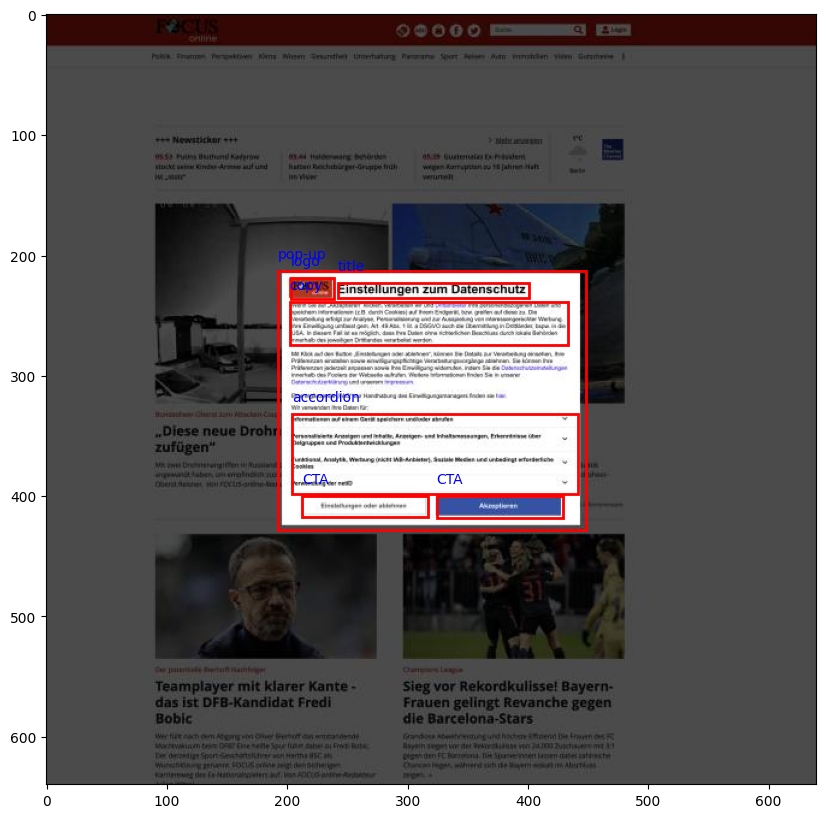

In [98]:
def plot_img_bbox(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10, 10)
    a.imshow(img)
    for i, box in enumerate(target['boxes']):
        #print(target['boxes'])
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
#         if arr[target['labels'][i]] == 'ad':
        rect = patches.Rectangle((x, y),
                                     width, height,
                                     linewidth = 2,
                                     edgecolor = 'r',
                                     facecolor = 'none')
        a.text(x, y-20, arr1[target['labels'][i]], color='b', verticalalignment='top')

        a.add_patch(rect)
    plt.show()

img, target = dataset12[40]
plot_img_bbox(img, target)

In [99]:
def get_object_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [100]:
def get_transform(train):
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [101]:
if __name__ == '__main__':
    dataset = PatternsImageSet('/content/dataset-v2-1/train', 640, 640, arr1, '/content/dataset-v2-1/train/_annotations.csv', transforms=get_transform(train=True))
    dataset_test = PatternsImageSet('/content/dataset-v2-1/test', 640, 640, arr1, '/content/dataset-v2-1/test/_annotations.csv', transforms=get_transform(train=False))

    torch.manual_seed(1)
    indices = torch.randperm(len(dataset)).tolist()

    test_split = 0.2
    tsize = int(len(dataset) * test_split)
    dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
    # dataset_test = torch.utils.data.Subset(dataset_test, indices[0:30])

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=3, shuffle=True, num_workers=4,
        collate_fn=collate)

    data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=3, shuffle=False, num_workers=4,
        collate_fn=collate)

In [102]:
len(data_loader)

351

In [103]:
for i in data_loader:
    print(i)
    # if(len(i[1][0]['boxes']) != len(i[1][0]['labels'])):
    #     print(i[1][0])

Streaming output truncated to the last 5000 lines.
         [0.0980, 0.0980, 0.0980,  ..., 0.0980, 0.0980, 0.0980],
         [0.0980, 0.0980, 0.0980,  ..., 0.0980, 0.0980, 0.0980]],

        [[0.2588, 0.2588, 0.2588,  ..., 0.2627, 0.2510, 0.2549],
         [0.2980, 0.2980, 0.2980,  ..., 0.3059, 0.2902, 0.2941],
         [0.7216, 0.7216, 0.7216,  ..., 0.7412, 0.7216, 0.7255],
         ...,
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216],
         [0.1216, 0.1216, 0.1216,  ..., 0.1216, 0.1216, 0.1216]],

        [[0.6745, 0.6745, 0.6706,  ..., 0.6824, 0.6706, 0.6745],
         [0.6196, 0.6196, 0.6118,  ..., 0.6118, 0.5961, 0.6000],
         [0.8471, 0.8471, 0.8471,  ..., 0.8157, 0.7961, 0.8000],
         ...,
         [0.1686, 0.1686, 0.1686,  ..., 0.1686, 0.1686, 0.1686],
         [0.1686, 0.1686, 0.1686,  ..., 0.1686, 0.1686, 0.1686],
         [0.1686, 0.1686, 0.1686,  ..., 0.1686, 0.1686, 0.1686]]]), tens

In [104]:
len(arr1)

40

In [105]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(arr1)

model = get_object_detection_model(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [106]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
  train_loss_list = []

  tqdm_bar = tqdm(data_loader, total=len(data_loader))
  print('Training started 0')

  for idx, data in enumerate(tqdm_bar):
    print('Training started 2')
#     print(data)

    optimizer.zero_grad()
    images, targets = data

    # print('---------------Image Section 0---------------')
    # print(images)
    # print(len(images))
    # print('---------------Targets Section 1---------------')
    # print(targets)
    # print(len(targets))

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]  # targets = {'boxes'=tensor, 'labels'=tensor}

    # print('---------------Image Section---------------')
    # print(images)
    # print(len(images))
    # print('---------------Targets Section---------------')
    # print(targets)
    # print(len(targets))

    losses = model(images, targets)

    loss = sum(loss for loss in losses.values())
    loss_val = loss.item()
    train_loss_list.append(loss.detach().cpu().numpy())

    loss.backward()
    optimizer.step()

    tqdm_bar.set_description(desc=f"Training Loss: {loss:.3f}")

  return train_loss_list

def evaluate(model, data_loader_test, device):
    val_loss_list = []

    tqdm_bar = tqdm(data_loader_test, total=len(data_loader_test))

    for i, data in enumerate(tqdm_bar):
        images, targets = data

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with torch.no_grad():
            losses = model(images, targets)

        loss = sum(loss for loss in losses.values())
        loss_val = loss.item()
        val_loss_list.append(loss_val)

        tqdm_bar.set_description(desc=f"Validation Loss: {loss:.4f}")
    return val_loss_list

def plot_loss(train_loss, valid_loss):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    train_ax.plot(train_loss, color='blue')
    train_ax.set_xlabel('Iteration')
    train_ax.set_ylabel('Training Loss')

    valid_ax.plot(valid_loss, color='red')
    valid_ax.set_xlabel('Iteration')
    valid_ax.set_ylabel('Validation loss')

    figure_1.savefig(f"{OUTPUT_DIR}/train_loss.png")
    figure_2.savefig(f"{OUTPUT_DIR}/valid_loss.png")

In [107]:
num_epochs = 25

In [108]:
import pickle

In [ ]:
# checkpoint_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith('.pth')]
# if checkpoint_files:
#     checkpoint_files.sort()
#     latest_checkpoint = os.path.join(OUTPUT_DIR, checkpoint_files[-1])

#     checkpoint = torch.load(latest_checkpoint)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch']
#     # loss_dict = checkpoint['loss_dict']
# else:
#     start_epoch = 0
#     loss_dict = {'train_loss': [], 'valid_loss': []}
loss_dict = {'train_loss': [], 'valid_loss': []}


for epoch in range(num_epochs):
  print("----------Epoch {}----------".format(epoch+1))

  train_loss_list = train_one_epoch(model, optimizer, data_loader, device, epoch)
  print('Training started 1')
  loss_dict['train_loss'].extend(train_loss_list)

  lr_scheduler.step()

  valid_loss_list = evaluate(model, data_loader_test, device)
  loss_dict['valid_loss'].extend(valid_loss_list)

  ckpt_file_name = f"{OUTPUT_DIR}/epoch__{epoch+1}__model.pth"
  torch.save({
    'epoch': epoch+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    # 'loss_dict': loss_dict
  }, ckpt_file_name)

  # plot_loss(loss_dict['train_loss'], loss_dict['valid_loss'])

# with open(f"{OUTPUT_DIR}/loss_dict.pkl", "wb") as file:
#     pickle.dump(loss_dict, file)

print("Training Finished !")

----------Epoch 1----------


  0%|          | 0/351 [00:00<?, ?it/s]

Training started 0
Training started 2


Training Loss: 11.631:   0%|          | 1/351 [00:01<08:29,  1.45s/it]

Training started 2


Training Loss: 4.367:   1%|          | 2/351 [00:02<05:36,  1.04it/s]

Training started 2


Training Loss: 4.588:   1%|          | 3/351 [00:02<04:33,  1.27it/s]

Training started 2


Training Loss: 4.135:   1%|          | 4/351 [00:03<04:02,  1.43it/s]

Training started 2


Training Loss: 4.762:   1%|▏         | 5/351 [00:03<03:47,  1.52it/s]

Training started 2


Training Loss: 4.281:   2%|▏         | 6/351 [00:04<03:38,  1.58it/s]

Training started 2


Training Loss: 3.020:   2%|▏         | 7/351 [00:04<03:29,  1.65it/s]

Training started 2


Training Loss: 2.432:   2%|▏         | 8/351 [00:05<03:22,  1.69it/s]

Training started 2


Training Loss: 2.574:   3%|▎         | 9/351 [00:06<03:18,  1.72it/s]

Training started 2


Training Loss: 3.243:   3%|▎         | 10/351 [00:06<03:16,  1.74it/s]

Training started 2


Training Loss: 4.330:   3%|▎         | 11/351 [00:07<03:14,  1.75it/s]

Training started 2


Training Loss: 2.910:   3%|▎         | 12/351 [00:07<03:13,  1.75it/s]

Training started 2


Training Loss: 3.058:   4%|▎         | 13/351 [00:08<03:12,  1.76it/s]

Training started 2


Training Loss: 2.878:   4%|▍         | 14/351 [00:08<03:11,  1.76it/s]

Training started 2


Training Loss: 3.381:   4%|▍         | 15/351 [00:09<03:10,  1.76it/s]

Training started 2


Training Loss: 3.036:   5%|▍         | 16/351 [00:10<03:09,  1.77it/s]

Training started 2


Training Loss: 2.597:   5%|▍         | 17/351 [00:10<03:09,  1.77it/s]

Training started 2


Training Loss: 2.936:   5%|▌         | 18/351 [00:11<03:08,  1.77it/s]

Training started 2


Training Loss: 2.153:   5%|▌         | 19/351 [00:11<03:07,  1.77it/s]

Training started 2


Training Loss: 2.706:   6%|▌         | 20/351 [00:12<03:06,  1.77it/s]

Training started 2


Training Loss: 2.357:   6%|▌         | 21/351 [00:12<03:06,  1.77it/s]

Training started 2


Training Loss: 3.004:   6%|▋         | 22/351 [00:13<03:06,  1.76it/s]

Training started 2


Training Loss: 2.794:   7%|▋         | 23/351 [00:13<03:06,  1.76it/s]

Training started 2


Training Loss: 3.271:   7%|▋         | 24/351 [00:14<03:07,  1.74it/s]

Training started 2


Training Loss: 4.085:   7%|▋         | 25/351 [00:15<03:08,  1.73it/s]

Training started 2


Training Loss: 1.969:   7%|▋         | 26/351 [00:15<03:09,  1.72it/s]

Training started 2


Training Loss: 2.215:   8%|▊         | 27/351 [00:16<03:08,  1.72it/s]

Training started 2


Training Loss: 2.186:   8%|▊         | 28/351 [00:16<03:10,  1.70it/s]

Training started 2


Training Loss: 3.412:   8%|▊         | 29/351 [00:17<03:10,  1.69it/s]

Training started 2


Training Loss: 2.371:   9%|▊         | 30/351 [00:18<03:08,  1.70it/s]

Training started 2


Training Loss: 2.225:   9%|▉         | 31/351 [00:18<03:06,  1.72it/s]

Training started 2


Training Loss: 2.586:   9%|▉         | 32/351 [00:19<03:04,  1.72it/s]

Training started 2


Training Loss: 2.868:   9%|▉         | 33/351 [00:19<03:03,  1.73it/s]

Training started 2


Training Loss: 2.111:  10%|▉         | 34/351 [00:20<03:02,  1.74it/s]

Training started 2


Training Loss: 3.754:  10%|▉         | 35/351 [00:20<03:01,  1.74it/s]

Training started 2


Training Loss: 2.272:  10%|█         | 36/351 [00:21<03:00,  1.74it/s]

Training started 2


Training Loss: 2.231:  11%|█         | 37/351 [00:22<02:59,  1.74it/s]

Training started 2


Training Loss: 1.959:  11%|█         | 38/351 [00:22<02:59,  1.74it/s]

Training started 2


Training Loss: 2.302:  11%|█         | 39/351 [00:23<02:59,  1.74it/s]

Training started 2


Training Loss: 2.297:  11%|█▏        | 40/351 [00:23<02:58,  1.75it/s]

Training started 2


Training Loss: 1.805:  12%|█▏        | 41/351 [00:24<02:57,  1.75it/s]

Training started 2


Training Loss: 2.247:  12%|█▏        | 42/351 [00:24<02:57,  1.74it/s]

Training started 2


Training Loss: 2.973:  12%|█▏        | 43/351 [00:25<02:57,  1.74it/s]

Training started 2


Training Loss: 2.244:  13%|█▎        | 44/351 [00:26<02:56,  1.74it/s]

Training started 2


Training Loss: 2.745:  13%|█▎        | 45/351 [00:26<02:55,  1.74it/s]

Training started 2


Training Loss: 2.586:  13%|█▎        | 46/351 [00:27<02:54,  1.74it/s]

Training started 2


Training Loss: 3.077:  13%|█▎        | 47/351 [00:27<02:55,  1.74it/s]

Training started 2


Training Loss: 4.340:  14%|█▎        | 48/351 [00:28<02:56,  1.71it/s]

Training started 2


Training Loss: 2.828:  14%|█▍        | 49/351 [00:29<02:59,  1.69it/s]

Training started 2


Training Loss: 1.447:  14%|█▍        | 50/351 [00:29<02:58,  1.68it/s]

Training started 2


Training Loss: 3.598:  15%|█▍        | 51/351 [00:30<02:58,  1.69it/s]

Training started 2


Training Loss: 3.786:  15%|█▍        | 52/351 [00:30<02:57,  1.68it/s]

Training started 2


Training Loss: 3.600:  15%|█▌        | 53/351 [00:31<02:55,  1.70it/s]

In [ ]:
loss_dict

In [ ]:
def apply_nms(orig_prediction, iou_thresh=0.3):
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)

    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]

    return final_prediction

def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [153]:
img, target = dataset12[5]

In [38]:
def inference(img, model, detection_threshold=0.70):
  '''
  Infernece of a single input image

  inputs:
    img: input-image as torch.tensor (shape: [C, H, W])
    model: model for infernce (torch.nn.Module)
    detection_threshold: Confidence-threshold for NMS (default=0.7)

  returns:
    boxes: bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    labels: class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    scores: confidence-score (Format [N] => N times confidence-score between 0 and 1)
  '''
  model.eval()

  img = torch.from_numpy(img).permute(2, 0, 1).float().to(device)
  outputs = model([img])

  boxes = outputs[0]['boxes'].data.cpu().numpy()
  scores = outputs[0]['scores'].data.cpu().numpy()
  labels = outputs[0]['labels'].data.cpu().numpy()

  boxes = boxes[scores >= detection_threshold].astype(np.int32)
  labels = labels[scores >= detection_threshold]
  scores = scores[scores >= detection_threshold]

  return boxes, scores, labels

In [39]:
import matplotlib.patches as patches

def plot_image(img, boxes, scores, labels, dataset, save_path=None):
  '''
  Function that draws the BBoxes, scores, and labels on the image.

  inputs:
    img: input-image as numpy.array (shape: [H, W, C])
    boxes: list of bounding boxes (Format [N, 4] => N times [xmin, ymin, xmax, ymax])
    scores: list of conf-scores (Format [N] => N times confidence-score between 0 and 1)
    labels: list of class-prediction (Format [N] => N times an number between 0 and _num_classes-1)
    dataset: list of all classes e.g. ["background", "class1", "class2", ..., "classN"] => Format [N_classes]
  '''

  cmap = plt.get_cmap("tab20b")
  class_labels = np.array(dataset)
  colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
  height, width, _ = img.shape
  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(16, 8))
  # Display the image
  ax.imshow(img)
  for i, box in enumerate(boxes):
    class_pred = labels[i]
    conf = scores[i]
    width = box[2] - box[0]
    height = box[3] - box[1]
    rect = patches.Rectangle(
        (box[0], box[1]),
        width,
        height,
        linewidth=2,
        edgecolor=colors[int(class_pred)],
        facecolor="none",
    )
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(
        box[0], box[1],
        s=class_labels[int(class_pred)] + " " + str(int(100*conf)) + "%",
        color="white",
        verticalalignment="top",
        bbox={"color": colors[int(class_pred)], "pad": 0},
    )

  # Used to save inference phase results
  if save_path is not None:
    plt.savefig(save_path)

  plt.show()

In [75]:
# num_images = 1

# for _ in range(num_images):
#   x = random.randint(0, (dataset_test.__len__()-1))
#   img, target = dataset_test.__getitem__(x)
#   img = img.to(device)


# img, target = dataset12.__getitem__(12)
img = cv2.imread('/content/dataset-v2-1/train/ebay-com_png.rf.f97c2a937e2ddb4c4025e5bf14e184aa.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
img_res = cv2.resize(img_rgb, (640, 640), cv2.INTER_AREA)
img_res /= 255.0

  # Load last checkpoint
  # CHANGE THE OUTPUT_DIR IF CKPT IS STORED ELSEWHERE
checkpoint_dir = f"{OUTPUT_DIR}/epoch__21_model.pth"
checkpoint = torch.load(checkpoint_dir, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

boxes, scores, labels = inference(img_res, model)

# img = img.transpose(1, 2, 0)  # Move channel dimension to the last axis

# if img.shape[2] == 1:
#     img = img.squeeze()  # Remove the third dimension if it has size 1
# else:
#     img = img.squeeze(0)  # Squeeze the batch dimension if it has size 1

# img = img.cpu().numpy()  # Convert to NumPy array
# img = img.clip(0, 1)  # Clip values to the valid range [0, 1]

# plot_image(img, boxes, scores, labels, arr1, save_path=f"{OUTPUT_DIR}/inference_{5}.png")

In [76]:
boxes

array([[ 31,   1, 597,  59],
       [ 71, 103, 121, 121],
       [162,  19, 474,  35],
       [534,   1, 542,  11],
       [ 77, 602, 134, 621],
       [ 69,  21,  82,  33],
       [259, 426, 325, 508],
       [ 82,  19,  93,  34],
       [439, 424, 524, 513],
       [121,  44, 522,  54],
       [135, 401, 179, 414]], dtype=int32)

In [77]:

target

{'boxes': tensor([[203., 219., 239., 236.],
         [242., 223., 401., 235.],
         [202., 239., 433., 274.],
         [212., 400., 317., 417.],
         [324., 400., 429., 418.],
         [204., 332., 442., 398.],
         [192., 213., 448., 428.]]),
 'labels': tensor([24, 36, 25,  9,  9,  1, 23]),
 'image_id': tensor([40])}

In [78]:
scores

array([0.9376805 , 0.9222284 , 0.9116115 , 0.8550886 , 0.82381594,
       0.7785669 , 0.77053654, 0.7570948 , 0.74902666, 0.70887554,
       0.7027069 ], dtype=float32)

In [79]:

labels

array([13,  9, 14, 32,  9, 32,  5, 32,  5, 11,  9])

In [80]:
def plot_img_bbox1(img, target):
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10, 10)
    a.imshow(img)
    for i, box in enumerate(target):

        #print(target)
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
#         if arr[target['labels'][i]] == 'ad':
        rect = patches.Rectangle((x, y),
                                     width, height,
                                     linewidth = 2,
                                     edgecolor = 'r',
                                     facecolor = 'none')
        a.text(x, y-20, arr1[labels[i]], color='b', verticalalignment='top')

        a.add_patch(rect)
    plt.show()

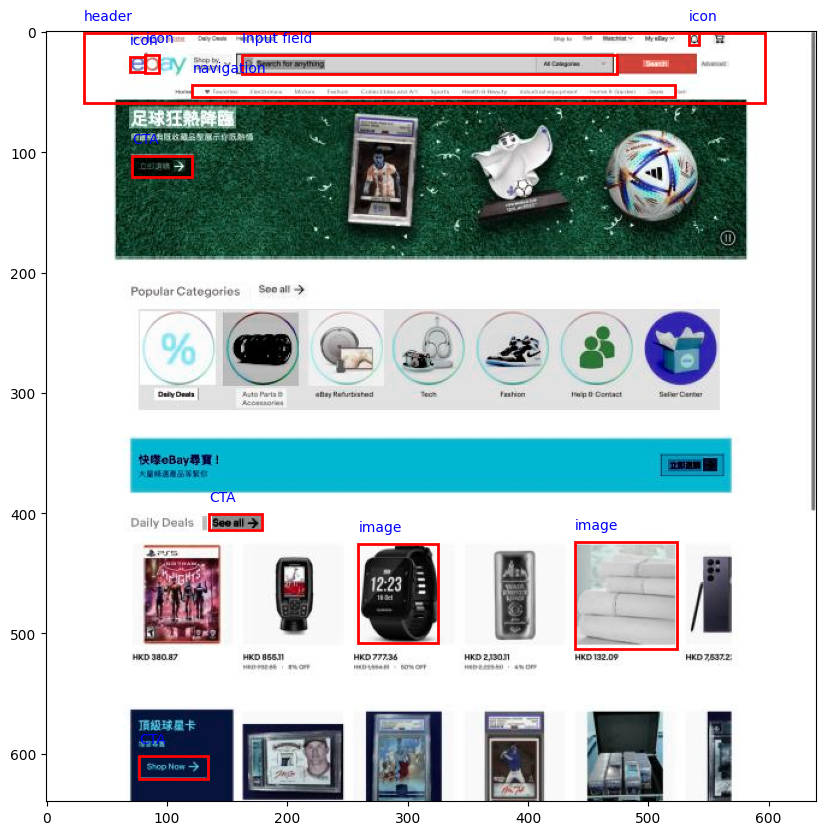

In [81]:
plot_img_bbox1(img, boxes)

In [74]:
target

{'boxes': tensor([[203., 219., 239., 236.],
         [242., 223., 401., 235.],
         [202., 239., 433., 274.],
         [212., 400., 317., 417.],
         [324., 400., 429., 418.],
         [204., 332., 442., 398.],
         [192., 213., 448., 428.]]),
 'labels': tensor([24, 36, 25,  9,  9,  1, 23]),
 'image_id': tensor([40])}

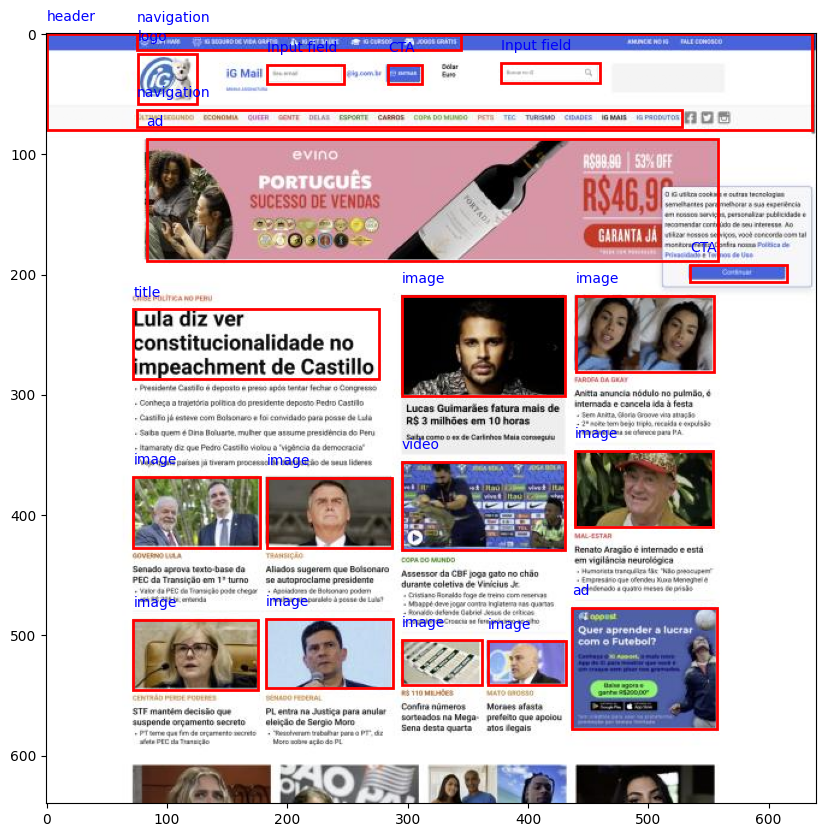

In [ ]:
plot_img_bbox(img, target)